# Possible effects of imaging duration on motility
---

#### Overview
The purpose of this notebook is to check for evidence of variation in cell motility over the course of an imaging experiment. I.e. what effects (if any) does time have on swimming behavior? The time scale involved in these experiments is on the order of several minutes.

Output from this notebook was used to generate Figure 4 in the [pub](https://doi.org/10.57844/arcadia-2d61-fb05).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

Configure matplotlib styles to match the Arcadia style guide

In [2]:
import arcadia_pycolor as apc

apc.mpl.setup()

#### Load motility data
Load motility data and set parameters relevant for subsequent regression analysis.

In [3]:
# load csv file of processed motility data from microchamber pools
csv_file = Path("../data/AMID-04_summary_motility_metrics.csv")
motility_dataframe = pd.read_csv(csv_file)

# duration of each time lapse for converting time lapse ID to time
timelapse_duration = 20 / 60  # minutes

# set metrics for regression analysis and map to axis labels for the plot
metrics_for_regression = [
    "total_time",
    "total_distance",
    "net_distance",
    "max_sprint_length",
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_linear_speed",
    "mean_angular_speed",
    "num_rotations",
    "num_direction_changes",
    "pivot_rate",
]
metrics_for_plot = {
    "confinement_ratio": "Confinement ratio",
    "mean_curvilinear_speed": "Mean curvilinear speed (µm/s)",
    "mean_angular_speed": "Mean angular speed (rad/s)",
}

#### Regression analysis
Generate a scatter plot that shows the variation of each specified motility metric across time. There are often multiple points per moment in time since multiple microchamber pools are present in the field of view of each time lapse.

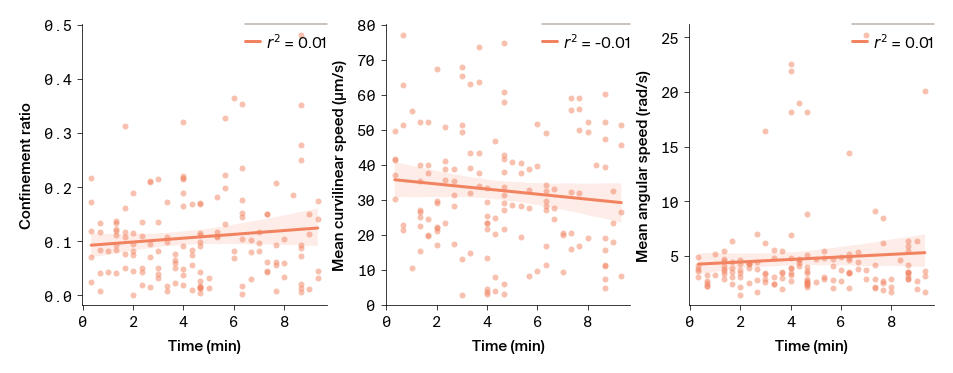

In [4]:
source = motility_dataframe.copy()
regression_dataframe = pd.DataFrame(columns=["metric", "r_squared", "p_value"])

# convert time lapse ID to time point
time_seconds = timelapse_duration * source["timelapse_ID"].values

# create figure
ncols = len(metrics_for_plot)
figsize = apc.mpl.get_figure_dimensions("full_wide")
fig, axes = plt.subplots(
    ncols=ncols,
    sharex=True,
    figsize=figsize,
    layout="constrained",
)

i_plot = 0  # counter for plotting
for i, metric in enumerate(metrics_for_regression):
    # regression stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(time_seconds, source[metric])
    r_squared = np.sign(r_value) * r_value**2

    # build up dataframe
    regression_dataframe.loc[i, "metric"] = metric
    regression_dataframe.loc[i, "r_squared"] = r_squared
    regression_dataframe.loc[i, "p_value"] = p_value

    if metric in metrics_for_plot:
        # scatter plot with regression line
        ylabel = metrics_for_plot[metric]
        ax = axes.flat[i_plot]
        g = sns.regplot(
            data=source,
            scatter=True,
            x=time_seconds,
            y=metric,
            line_kws={"label": f"$r^2$ = {r_squared:.2f}"},
            scatter_kws={"alpha": 0.5},
            color="#F28360",
            ax=ax,
        )
        # aesthetics
        ax.set_xlabel("Time (min)")
        ax.set_ylabel(ylabel)
        ax.legend(loc=1)
        sns.despine(ax=ax)
        apc.mpl.style_plot(ax, monospaced_axes="both")

        i_plot += 1

# save output
regression_dataframe.to_csv("../results/figure-4_regression_stats.csv", index=False)
apc.mpl.save_figure("../results/figure-4.svg")

In [5]:
# show regression stats
print(regression_dataframe)

                    metric r_squared   p_value
0               total_time  0.000001  0.993133
1           total_distance -0.009595  0.241149
2             net_distance -0.002543  0.546902
3        max_sprint_length -0.026991   0.04831
4        confinement_ratio  0.011444  0.200303
5   mean_curvilinear_speed -0.012137  0.187122
6        mean_linear_speed -0.002889  0.520791
7       mean_angular_speed  0.005343  0.382245
8            num_rotations  0.016233  0.126718
9    num_direction_changes  0.003874  0.457043
10              pivot_rate  0.000549  0.779748
